In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from  sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import KFold
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data_train = pd.read_csv('features.csv', index_col='match_id')
data_train.shape

(97230, 108)

In [3]:
data_test = pd.read_csv('features_test.csv', index_col='match_id')
data_test.shape

(17177, 102)

In [4]:
# Drop features are not in the test
match_res = ['duration', 'tower_status_radiant',
             'tower_status_dire','barracks_status_radiant', 'barracks_status_dire' ]
for col_name in match_res:
    data_train.drop(col_name, axis=1 , inplace = True)

In [5]:
# Sergey's features
domin_train = pd.read_csv('dom0.csv', index_col = 'match_id')
for i in range(1, 20):
    domin_train = pd.concat([domin_train, pd.read_csv('dom{}.csv'.format(i), index_col='match_id')])
    
domin_test = pd.read_csv('dom_t0.csv', index_col = 'match_id')
for i in range(1, 4):
    domin_test = pd.concat([domin_test, pd.read_csv('dom_t{}.csv'.format(i), index_col='match_id')])

data_train = pd.concat([data_train, domin_train], axis=1)
data_test = pd.concat([data_test, domin_test], axis=1)

In [6]:
# All purchases


# Drop to avoid replays
data_train.drop('radiant_tpscroll_count', axis=1, inplace=True)
data_train.drop('radiant_boots_count', axis=1, inplace=True)
data_train.drop('radiant_ward_observer_count', axis=1, inplace=True)
data_train.drop('radiant_ward_sentry_count', axis=1, inplace=True)

data_train.drop('dire_tpscroll_count', axis=1, inplace=True)
data_train.drop('dire_boots_count', axis=1, inplace=True)
data_train.drop('dire_ward_observer_count', axis=1, inplace=True)
data_train.drop('dire_ward_sentry_count', axis=1, inplace=True)


data_test.drop('radiant_tpscroll_count', axis=1, inplace=True)
data_test.drop('radiant_boots_count', axis=1, inplace=True)
data_test.drop('radiant_ward_observer_count', axis=1, inplace=True)
data_test.drop('radiant_ward_sentry_count', axis=1, inplace=True)

data_test.drop('dire_tpscroll_count', axis=1, inplace=True)
data_test.drop('dire_boots_count', axis=1, inplace=True)
data_test.drop('dire_ward_observer_count', axis=1, inplace=True)
data_test.drop('dire_ward_sentry_count', axis=1, inplace=True)

# build files for train
tmp0 = pd.read_csv('tmp0.csv')
tmp1 = pd.read_csv('tmp1.csv')
tmp1.columns = tmp0.columns
tmp2 = pd.read_csv('tmp2.csv')
tmp2.columns = tmp0.columns
items_train = pd.concat([tmp0, tmp1, tmp2])
items_train = items_train.set_index(data_train.index) #['match_id']
items_train.drop('match_id', axis=1, inplace=True)

# build files for test
items_test = pd.read_csv('items_test_.csv', index_col = 'match_id')

data_train = pd.concat([data_train, items_train], axis=1)
data_test = pd.concat([data_test, items_test], axis=1)

In [7]:
target = 'radiant_win'
predictors = [col_name for col_name in data_train.columns if col_name != target]
new_predictors = []

In [8]:
# Features with missing values
for col_name in predictors:
    if data_train[col_name].isnull().values.any():
        print (col_name)

first_blood_time
first_blood_team
first_blood_player1
first_blood_player2
radiant_bottle_time
radiant_courier_time
radiant_flying_courier_time
radiant_first_ward_time
dire_bottle_time
dire_courier_time
dire_flying_courier_time
dire_first_ward_time


In [9]:
data = pd.concat([data_train, data_test])

In [10]:
data['bottle'] = (data.radiant_bottle_time > 0) * 1 + (data.dire_bottle_time > 0) * -1

data['courier'] = (data.radiant_courier_time > 0) * -1 + (data.dire_courier_time > 0) * 1

data['flying_courier'] = (data.radiant_flying_courier_time > 0) * 1 + (data.dire_flying_courier_time > 0) * -1

data['first_ward'] = ((data.radiant_first_ward_time > 0) & (data.radiant_first_ward_time < 150)) * 1 + \
((data.dire_first_ward_time > 0) & (data.dire_first_ward_time < 150)) * -1
new_predictors.extend(['bottle', 'courier', 'flying_courier', 'first_ward'])

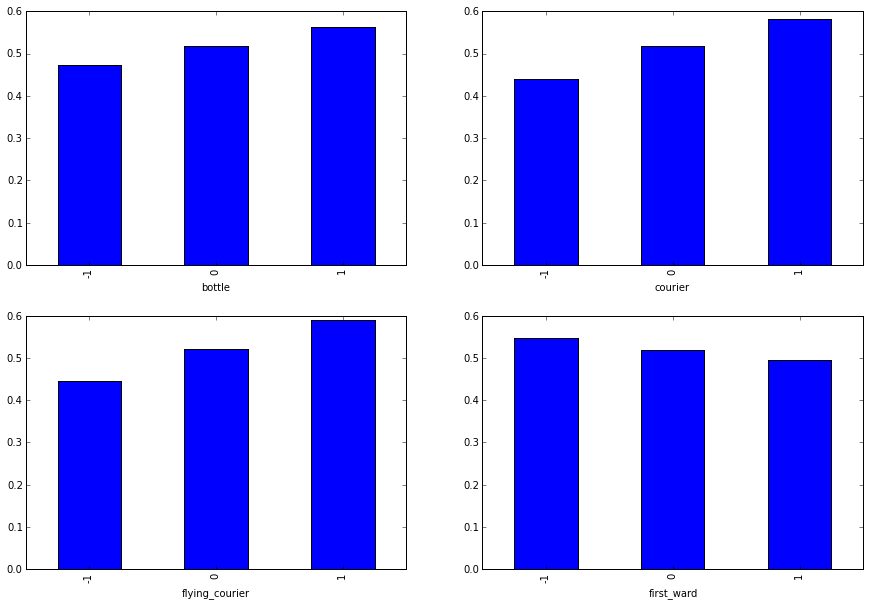

In [11]:
# The impact of buying these items on target
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
for i, f in enumerate(['bottle', 'courier', 'flying_courier', 'first_ward']):
    data.groupby(f)['radiant_win'].mean().plot.bar(ax=axs[i // 2][i % 2])

In [12]:
n_samples =  data_train.shape[0]
data_train = data[:n_samples].copy()
data_test = data[n_samples:].copy()
data_test.drop(target, axis=1, inplace=True)

In [13]:
predictors = [col_name for col_name in data.columns if col_name != target]

In [14]:
# Replace missing values with median (more resistant to the noise)
# add out-of-fold feature: 1 - missing value, 0 - not 

for col_name in predictors:
    median = data_train[col_name].median()
    
    if data_train[col_name].isnull().any():
        data_train['isnull_{}'.format(col_name)] = \
                                             data_train[col_name].isnull().astype(int)
        data_train[col_name] = data_train[col_name].replace(np.nan, median)
        
        data_test['isnull_{}'.format(col_name)] = \
                                             data_test[col_name].isnull().astype(int)
        data_test[col_name] = data_test[col_name].replace(np.nan, median)
        
        new_predictors.append('isnull_{}'.format(col_name))    

In [15]:
# Synergy steam players
def calc_rating(data):
    N = 113 # heroes

    # calculate each hero-pair synergy and antisynergy
    synergy = np.zeros((N,N))     # sum of wins in matches played together
    antisynergy = np.zeros((N,N)) # sum of wins when played against
    matchcounts = np.zeros((N,N)) # count of matches played together
    matchcounta = np.zeros((N,N)) # count of matches played against
    
    for match_counter, match_id in enumerate(data.index):
        #synergy when both heroes in win team
        winteam = 'r' if data.ix[match_id, 'radiant_win'] == 1 else 'd'
        looseteam = 'd' if winteam =='r' else 'r'
        pind     = [0] *5 #player indexes    
        antipind = [0] *5 # looser indicies
        # get indexes of players in each team
        for i in range(5):
            pind[i] = data.ix[match_id, winteam+'%d_hero'%(i+1)]-1
        for i in range(5):
            antipind[i] = data.ix[match_id, looseteam+'%d_hero'%(i+1)]-1
        # accumulate synergy of pairs
        for i in range(5):
            for j in range(i+1,5):
                synergy[pind[i], pind[j]] +=1
                synergy[pind[j], pind[i]] +=1
        # accumulate match counter for playing together
        for i in range(5):
            for j in range(5):
                matchcounts[pind[i], pind[j]] +=1 #together and win
                matchcounts[antipind[i], antipind[j]] +=1 # together and loose
                
        #antisynergy when hero i in winteam while hero j in loose team
        for i in range(5):
            for j in range(5):
                antisynergy[pind[i], antipind[j]] +=1
                matchcounta[pind[i], antipind[j]] +=1
                matchcounta[antipind[j], pind[i]] +=1
        
    # normalize
    synergyrate = np.zeros((N,N))
    antisynergyrate = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            if matchcounts[i,j] !=0:
                synergyrate[i,j] = synergy[i,j]/matchcounts[i,j] 
            else:
                synergyrate[i,j] = 0.5  
            if matchcounta[i,j] !=0:
                antisynergyrate[i,j] = antisynergy[i,j]/ matchcounta[i,j]
            else:
                antisynergyrate[i,j] = 0.5      

    return  synergyrate, antisynergyrate

In [16]:
# Synergy, folding for train

data_train['synergy'] = 0.0
data_train['antisynergy'] = 0.0

kf = KFold(data_train.shape[0], 10)

for i1, j1 in kf:
    data_train_ = data_train.iloc[i1]
    data_test_ =  data_train.iloc[j1]
    synergyrate, antisynergyrate = calc_rating(data_train_)  
    syn = np.zeros(data_test_.shape[0])
    antisyn = np.zeros(data_test_.shape[0])
    
    for match_counter, match_id in enumerate(data_test_.index):
        rind = [0] *5 #radiant indicies    
        dind = [0] *5 # dire indicies
        
        # get indexes of players in each team
        for i in range(5):
            rind[i] = data_test_.ix[match_id, 'r%d_hero'%(i+1)]-1
        for i in range(5):
            dind[i] = data_test_.ix[match_id, 'd%d_hero'%(i+1)]-1
            
        # accumulate synergy of radiants minus synergy of dires
        
        # + radiants synergy
        for i in range(5):
            for j in range(i+1,5):
                syn[match_counter] += synergyrate[rind[i], rind[j]]
        # - dire synergy
        for i in range(5):
            for j in range(i+1,5):
                syn[match_counter] -= synergyrate[dind[i], dind[j]]
        # accumulate antisynergy
        for i in range(5):
            for j in range(5):
                antisyn[match_counter] += antisynergyrate[rind[i], dind[j]] 
                
    data_train.loc[data_test_.index, 'synergy'] = syn
    data_train.loc[data_test_.index, 'antisynergy'] = antisyn

    
new_predictors.extend(['synergy', 'antisynergy'])

In [17]:
# Synergy, for test 

data_test['synergy'] = 0.0
data_test['antisynergy'] = 0.0

synergyrate, antisynergyrate = calc_rating(data_train)  
syn = np.zeros(data_test.shape[0])
antisyn = np.zeros(data_test.shape[0])
    
for match_counter, match_id in enumerate(data_test.index):
    rind = [0] *5 #radiant indicies    
    dind = [0] *5 # dire indicies
        
    # get indexes of players in each team
    for i in range(5):
        rind[i] = data_test.ix[match_id, 'r%d_hero'%(i+1)]-1
    for i in range(5):
        dind[i] = data_test.ix[match_id, 'd%d_hero'%(i+1)]-1
            
    # accumulate synergy of radiants minus synergy of dires
        
    # + radiants synergy
    for i in range(5):
        for j in range(i+1,5):
            syn[match_counter] += synergyrate[rind[i], rind[j]]
    # - dire synergy
    for i in range(5):
        for j in range(i+1,5):
            syn[match_counter] -= synergyrate[dind[i], dind[j]]
    # accumulate antisynergy
    for i in range(5):
        for j in range(5):
            antisyn[match_counter] += antisynergyrate[rind[i], dind[j]] 


data_test['synergy'] = syn
data_test['antisynergy'] = antisyn    

In [18]:
# For binarization
data = pd.concat([data_train, data_test])

In [9]:
# Works as well as indicators
shop = ['bottle_time', 'courier_time', 'flying_courier_time', 'first_ward_time']
for f in shop:
    data['shop_ind_{}'.format(f)] = data['isnull_dire_{}'.format(f)] - data['isnull_radiant_{}'.format(f)] 
    new_predictors.append('shop_ind_{}'.format(f)) 
    data.drop('isnull_dire_{}'.format(f), axis=1, inplace=True)
    data.drop('isnull_radiant_{}'.format(f), axis=1, inplace=True)

/root/miniconda/envs/jupyterhub_py3/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/root/miniconda/envs/jupyterhub_py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


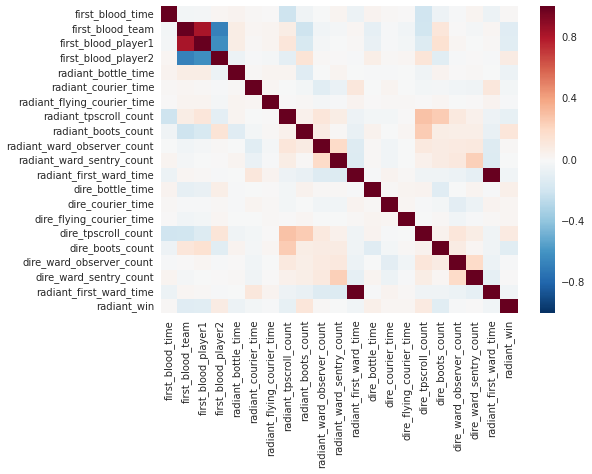

In [11]:
import seaborn
corr = ['first_blood_time', 'first_blood_team', 
        'first_blood_player1', 'first_blood_player2',
        'radiant_bottle_time', 'radiant_courier_time', 'radiant_flying_courier_time',
        'radiant_tpscroll_count', 'radiant_boots_count', 'radiant_ward_observer_count',
        'radiant_ward_sentry_count', 'radiant_first_ward_time', 
        'dire_bottle_time', 'dire_courier_time', 'dire_flying_courier_time',
        'dire_tpscroll_count', 'dire_boots_count', 'dire_ward_observer_count',
        'dire_ward_sentry_count', 'radiant_first_ward_time', 'radiant_win']

seaborn.heatmap(data[corr].corr())

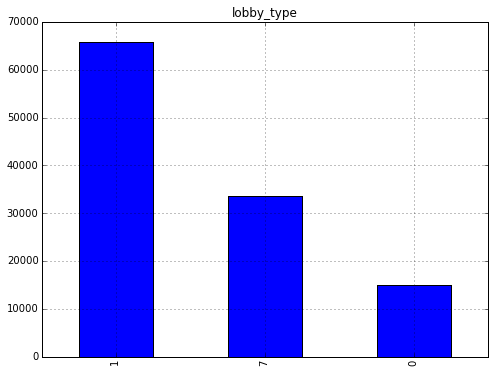

In [8]:
fig = figure(figsize=(8, 6))
data.lobby_type.value_counts().plot(kind='bar')
grid()
title('lobby_type')
show()

In [19]:
# Categorical feature lobby_type {0, 1, 7}, one-hot-encoding
lobby_type  = pd.get_dummies(data.lobby_type)
data.drop('lobby_type', axis=1, inplace=True)
lobby_type.columns = ['lb_0', 'lb_1', 'lb_7']
data = pd.concat([data, lobby_type], axis = 1)

new_predictors.extend(lobby_type.columns)

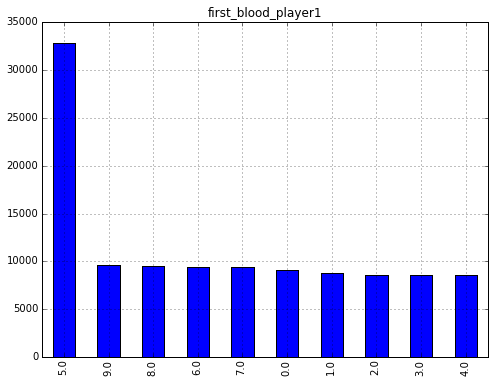

In [11]:
fig = figure(figsize=(8, 6))
data.first_blood_player1.value_counts().plot(kind='bar')
grid()
title('first_blood_player1')
show()

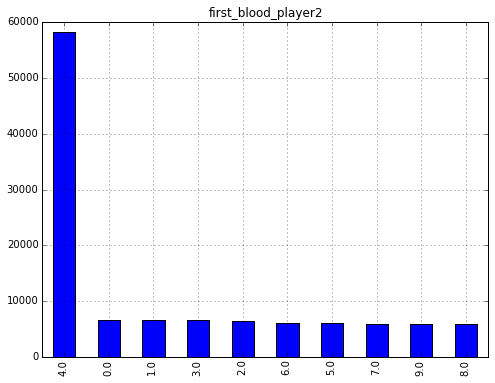

In [12]:
fig = figure(figsize=(8, 6))
data.first_blood_player2.value_counts().plot(kind='bar')
grid()
title('first_blood_player2')
show()

In [20]:
# Categorical features first_blood_player1, first_blood_player2 {0.0 ... 0.9}, one-hot-encoding

player1  = pd.get_dummies(data.first_blood_player1)
player2  = pd.get_dummies(data.first_blood_player2)

player1.columns = ['player1_{}'.format(i) for i in range(10)]
player2.columns = ['player2_{}'.format(i) for i in range(10)]

data  = pd.concat([data, player1, player2], axis=1)
data.drop('first_blood_player1', axis=1, inplace=True)
data.drop('first_blood_player2', axis=1, inplace=True)

new_predictors.extend(player1.columns)
new_predictors.extend(player2.columns)

In [21]:
r_players = ['r{}_hero'.format(i) for i in range(1,6)]
d_players = ['d{}_hero'.format(i) for i in range(1,6)]
players = r_players + d_players
for player in players:
    print(player,
          np.unique(data[player]).size)

r1_hero 108
r2_hero 108
r3_hero 108
r4_hero 108
r5_hero 108
d1_hero 108
d2_hero 108
d3_hero 108
d4_hero 108
d5_hero 108


In [22]:
# one-hot-encoding of heros
N = np.unique(data['r1_hero'])[-1]
X_pick = np.zeros((data.shape[0], N))

for i, match_id in enumerate(data.index):
    for p in range(5):
            X_pick[i, data.ix[match_id, 'r%d_hero' % (p+1)]-1] = 1
            X_pick[i, data.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1
    

heros = pd.DataFrame(X_pick, index = data.index, columns=['hero_{}'.format(i) for i in range(N)])
data = pd.concat([data, heros], axis=1)
for player in players:
    data.drop(player, axis=1, inplace=True)
    
new_predictors.extend(['hero_{}'.format(i) for i in range(N)])

In [ ]:
# This way works worse
f_hero = ['level', 'xp', 'gold', 'lh', 'kills', 'deaths', 'items']
for f in f_hero:
    data['r_{}_sum'.format(f)] = \
               data[['r{}_{}'.format(i, f) for i in range(1,6)]].sum(axis = 1)
    data['d_{}_sum'.format(f)] = \
               data[['d{}_{}'.format(i, f) for i in range(1,6)]].sum(axis = 1)  
        
    for i in range(1, 6):
        data.drop('r{}_{}'.format(i, f), inplace=True)
        data.drop('d{}_{}'.format(i, f), inplace=True)

In [23]:
# Calculate relative values

f_hero = ['level','xp', 'gold', 'lh', 'kills', 'deaths', 'items',
          'win_gold', 'win_xp', 'win_lh', 'lose_gold', 'lose_xp', 'lose_lh', 
          'domin_gold', 'domin_xp', 'domin_lh', 'domin2_gold', 'domin2_xp', 'domin2_lh']
for f in f_hero: 
    sum_r = data[['r{}_{}'.format(i, f) for i in range(1,6)]].sum(axis = 1)
    sum_d = data[['d{}_{}'.format(i, f) for i in range(1,6)]].sum(axis = 1)
    
    mean_r = data[['r{}_{}'.format(i, f) for i in range(1,6)]].sum(axis = 1)
    mean_d = data[['d{}_{}'.format(i, f) for i in range(1,6)]].sum(axis = 1)
    
    max_r = data[['r{}_{}'.format(i, f) for i in range(1,6)]].max(axis = 1)
    max_d = data[['d{}_{}'.format(i, f) for i in range(1,6)]].max(axis = 1)
    
    min_r = data[['r{}_{}'.format(i, f) for i in range(1,6)]].min(axis = 1)
    min_d = data[['d{}_{}'.format(i, f) for i in range(1,6)]].min(axis = 1)
    
    std_r = data[['r{}_{}'.format(i, f) for i in range(1,6)]].std(axis = 1)
    std_d = data[['d{}_{}'.format(i, f) for i in range(1,6)]].std(axis = 1)
    
    data['diff_sum_{}'.format(f)] = sum_r - sum_d
    data['diff_norm_sum_{}'.format(f)] = (sum_r - sum_d) / sqrt (abs(sum_r) + abs(sum_d) ).replace(0, 1)
    new_predictors.append('diff_norm_sum_{}'.format(f))
    
    #data['diff_div_{}'.format(f)] = sum_r / sum_d.replace(0, 1)
    
    data['diff_max_{}'.format(f)] = max_r - max_d
    data['diff_norm_max_{}'.format(f)] = (max_r - max_d) / sqrt (abs(max_r) + abs(max_d) ).replace(0, 1)
    new_predictors.append('diff_norm_max_{}'.format(f))
    
    data['diff_min_{}'.format(f)] = min_r - min_d
    data['diff_norm_min_{}'.format(f)] = (min_r - min_d) / sqrt(abs(min_r) + abs(min_d) ).replace(0, 1)
    new_predictors.append('diff_norm_min_{}'.format(f))
    
    data['diff_std_{}'.format(f)] = std_r - std_d
    data['diff_norm_std_{}'.format(f)] = (std_r - std_d) / sqrt(abs(std_r) + abs(std_d) ).replace(0, 1)
    new_predictors.append('diff_norm_std_{}'.format(f))
    #if f == 'xp':
    #    data['r_max_xp'] = max_r
    #    data['d_max_xp'] = max_d
    for i in range(1, 6):
        data.drop('r{}_{}'.format(i, f), axis=1, inplace=True)
        data.drop('d{}_{}'.format(i, f), axis=1, inplace=True)

In [26]:
outliers = ['branches_count', 
           'enchanted_mango_count', 
           'tpscroll_count', 
           'mantle_count', 
           'belt_of_strength_count', 
           'circlet_count', 
           'ring_of_regen_count', 
           'sobi_mask_count', 
           'tango_count', 
           'ring_of_health_count', 
           'wraith_band_count', 
           'null_talisman_count', 
           'headdress_count', 
           'smoke_of_deceit_count', 
           'tranquil_boots_count']

### Works with outliers

In [27]:
f = 'branches_count'
data['diff_{}'.format(f)] = data['radiant_{}'.format(f)] - data['dire_{}'.format(f)]
data.ix[data.diff_branches_count > 10, 'diff_branches_count'] = 10
data.ix[data.diff_branches_count < -10, 'diff_branches_count'] = -10

data['diff_norm_{}'.format(f)] = (data['radiant_{}'.format(f)] - data['dire_{}'.format(f)]) / \
    sqrt(abs(data['radiant_{}'.format(f)]) + abs(data['dire_{}'.format(f)])).replace(0, 1)
new_predictors.append('diff_norm_{}'.format(f))
data.drop('radiant_{}'.format(f), axis=1, inplace=True)
data.drop('dire_{}'.format(f), axis=1, inplace=True)

In [28]:
f = 'enchanted_mango_count'
data['diff_{}'.format(f)] = data['radiant_{}'.format(f)] - data['dire_{}'.format(f)]
data.ix[data.diff_enchanted_mango_count > 5, 'diff_enchanted_mango_count'] = 5
data.ix[data.diff_enchanted_mango_count < -5, 'diff_enchanted_mango_count'] = -5

data['diff_norm_{}'.format(f)] = (data['radiant_{}'.format(f)] - data['dire_{}'.format(f)]) / \
    sqrt(abs(data['radiant_{}'.format(f)]) + abs(data['dire_{}'.format(f)])).replace(0, 1)
new_predictors.append('diff_norm_{}'.format(f))
data.drop('radiant_{}'.format(f), axis=1, inplace=True)
data.drop('dire_{}'.format(f), axis=1, inplace=True)

In [29]:
f = 'tpscroll_count'
data['diff_{}'.format(f)] = data['radiant_{}'.format(f)] - data['dire_{}'.format(f)]
data.ix[data.diff_tpscroll_count > 10, 'diff_tpscroll_count'] = 10
data.ix[data.diff_tpscroll_count < -10, 'diff_tpscroll_count'] = -10

data['diff_norm_{}'.format(f)] = (data['radiant_{}'.format(f)] - data['dire_{}'.format(f)]) / \
    sqrt(abs(data['radiant_{}'.format(f)]) + abs(data['dire_{}'.format(f)])).replace(0, 1)
new_predictors.append('diff_norm_{}'.format(f))
data.drop('radiant_{}'.format(f), axis=1, inplace=True)
data.drop('dire_{}'.format(f), axis=1, inplace=True)

In [30]:
f = 'mantle_count'
data['diff_{}'.format(f)] = data['radiant_{}'.format(f)] - data['dire_{}'.format(f)]
data.ix[data.diff_mantle_count > 3, 'diff_mantle_count'] = 3
data.ix[data.diff_mantle_count < -3, 'diff_mantle_count'] = -3

data['diff_norm_{}'.format(f)] = (data['radiant_{}'.format(f)] - data['dire_{}'.format(f)]) / \
    sqrt(abs(data['radiant_{}'.format(f)]) + abs(data['dire_{}'.format(f)])).replace(0, 1)
new_predictors.append('diff_norm_{}'.format(f))
data.drop('radiant_{}'.format(f), axis=1, inplace=True)
data.drop('dire_{}'.format(f), axis=1, inplace=True)

In [31]:
f = 'belt_of_strength_count'
data['diff_{}'.format(f)] = data['radiant_{}'.format(f)] - data['dire_{}'.format(f)]
data.ix[data.diff_belt_of_strength_count > 2, 'diff_belt_of_strength_count'] = 2
data.ix[data.diff_belt_of_strength_count < -2, 'diff_belt_of_strength_count'] = -2

data['diff_norm_{}'.format(f)] = (data['radiant_{}'.format(f)] - data['dire_{}'.format(f)]) / \
    sqrt(abs(data['radiant_{}'.format(f)]) + abs(data['dire_{}'.format(f)])).replace(0, 1)
new_predictors.append('diff_norm_{}'.format(f))
data.drop('radiant_{}'.format(f), axis=1, inplace=True)
data.drop('dire_{}'.format(f), axis=1, inplace=True)

In [32]:
f = 'circlet_count'
data['diff_{}'.format(f)] = data['radiant_{}'.format(f)] - data['dire_{}'.format(f)]
data.ix[data.diff_circlet_count > 8, 'diff_circlet_count'] = 8
data.ix[data.diff_circlet_count < -6, 'diff_circlet_count'] = -6

data['diff_norm_{}'.format(f)] = (data['radiant_{}'.format(f)] - data['dire_{}'.format(f)]) / \
    sqrt(abs(data['radiant_{}'.format(f)]) + abs(data['dire_{}'.format(f)])).replace(0, 1)
new_predictors.append('diff_norm_{}'.format(f))
data.drop('radiant_{}'.format(f), axis=1, inplace=True)
data.drop('dire_{}'.format(f), axis=1, inplace=True)

In [33]:
f = 'ring_of_regen_count'
data['diff_{}'.format(f)] = data['radiant_{}'.format(f)] - data['dire_{}'.format(f)]
data.ix[data.diff_ring_of_regen_count > 6, 'diff_ring_of_regen_count'] = 6

data['diff_norm_{}'.format(f)] = (data['radiant_{}'.format(f)] - data['dire_{}'.format(f)]) / \
    sqrt(abs(data['radiant_{}'.format(f)]) + abs(data['dire_{}'.format(f)])).replace(0, 1)
new_predictors.append('diff_norm_{}'.format(f))
data.drop('radiant_{}'.format(f), axis=1, inplace=True)
data.drop('dire_{}'.format(f), axis=1, inplace=True)

In [34]:
f = 'sobi_mask_count'
data['diff_{}'.format(f)] = data['radiant_{}'.format(f)] - data['dire_{}'.format(f)]
data.ix[data.diff_sobi_mask_count > 6, 'diff_sobi_mask_count'] = 6
data.ix[data.diff_sobi_mask_count < -6, 'diff_sobi_mask_count'] = -6

data['diff_norm_{}'.format(f)] = (data['radiant_{}'.format(f)] - data['dire_{}'.format(f)]) / \
    sqrt(abs(data['radiant_{}'.format(f)]) + abs(data['dire_{}'.format(f)])).replace(0, 1)
new_predictors.append('diff_norm_{}'.format(f))
data.drop('radiant_{}'.format(f), axis=1, inplace=True)
data.drop('dire_{}'.format(f), axis=1, inplace=True)

In [35]:
f = 'tango_count'
data['diff_{}'.format(f)] = data['radiant_{}'.format(f)] - data['dire_{}'.format(f)]
data.ix[data.diff_tango_count > 7, 'diff_tango_count'] = 7
data.ix[data.diff_tango_count < -7, 'diff_tango_count'] = -7

data['diff_norm_{}'.format(f)] = (data['radiant_{}'.format(f)] - data['dire_{}'.format(f)]) / \
    sqrt(abs(data['radiant_{}'.format(f)]) + abs(data['dire_{}'.format(f)])).replace(0, 1)
new_predictors.append('diff_norm_{}'.format(f))
data.drop('radiant_{}'.format(f), axis=1, inplace=True)
data.drop('dire_{}'.format(f), axis=1, inplace=True)

In [36]:
f = 'ring_of_health_count'
data['diff_{}'.format(f)] = data['radiant_{}'.format(f)] - data['dire_{}'.format(f)]
data.ix[data.diff_ring_of_health_count > 2, 'diff_ring_of_health_count'] = 2

data['diff_norm_{}'.format(f)] = (data['radiant_{}'.format(f)] - data['dire_{}'.format(f)]) / \
    sqrt(abs(data['radiant_{}'.format(f)]) + abs(data['dire_{}'.format(f)])).replace(0, 1)
new_predictors.append('diff_norm_{}'.format(f))
data.drop('radiant_{}'.format(f), axis=1, inplace=True)
data.drop('dire_{}'.format(f), axis=1, inplace=True)

In [37]:
f = 'wraith_band_count'
data['diff_{}'.format(f)] = data['radiant_{}'.format(f)] - data['dire_{}'.format(f)]
data.ix[data.diff_wraith_band_count > 4, 'diff_wraith_band_count'] = 4

data['diff_norm_{}'.format(f)] = (data['radiant_{}'.format(f)] - data['dire_{}'.format(f)]) / \
    sqrt(abs(data['radiant_{}'.format(f)]) + abs(data['dire_{}'.format(f)])).replace(0, 1)
new_predictors.append('diff_norm_{}'.format(f))
data.drop('radiant_{}'.format(f), axis=1, inplace=True)
data.drop('dire_{}'.format(f), axis=1, inplace=True)

In [38]:
f = 'null_talisman_count'
data['diff_{}'.format(f)] = data['radiant_{}'.format(f)] - data['dire_{}'.format(f)]
data.ix[data.diff_null_talisman_count > 4, 'diff_null_talisman_count'] = 4

data['diff_norm_{}'.format(f)] = (data['radiant_{}'.format(f)] - data['dire_{}'.format(f)]) / \
    sqrt(abs(data['radiant_{}'.format(f)]) + abs(data['dire_{}'.format(f)])).replace(0, 1)
new_predictors.append('diff_norm_{}'.format(f))
data.drop('radiant_{}'.format(f), axis=1, inplace=True)
data.drop('dire_{}'.format(f), axis=1, inplace=True)

In [39]:
f = 'headdress_count'
data['diff_{}'.format(f)] = data['radiant_{}'.format(f)] - data['dire_{}'.format(f)]
data.ix[data.diff_headdress_count > 1, 'diff_headdress_count'] = 1

data['diff_norm_{}'.format(f)] = (data['radiant_{}'.format(f)] - data['dire_{}'.format(f)]) / \
    sqrt(abs(data['radiant_{}'.format(f)]) + abs(data['dire_{}'.format(f)])).replace(0, 1)
new_predictors.append('diff_norm_{}'.format(f))
data.drop('radiant_{}'.format(f), axis=1, inplace=True)
data.drop('dire_{}'.format(f), axis=1, inplace=True)

In [40]:
f = 'smoke_of_deceit_count'
data['diff_{}'.format(f)] = data['radiant_{}'.format(f)] - data['dire_{}'.format(f)]
data.ix[data.diff_smoke_of_deceit_count > 5, 'diff_smoke_of_deceit_count'] = 5
data.ix[data.diff_smoke_of_deceit_count < -5, 'diff_smoke_of_deceit_count'] = -5

data['diff_norm_{}'.format(f)] = (data['radiant_{}'.format(f)] - data['dire_{}'.format(f)]) / \
    sqrt(abs(data['radiant_{}'.format(f)]) + abs(data['dire_{}'.format(f)])).replace(0, 1)
new_predictors.append('diff_norm_{}'.format(f))
data.drop('radiant_{}'.format(f), axis=1, inplace=True)
data.drop('dire_{}'.format(f), axis=1, inplace=True)

In [41]:
f = 'tranquil_boots_count'
data['diff_{}'.format(f)] = data['radiant_{}'.format(f)] - data['dire_{}'.format(f)]
data.ix[data.diff_tranquil_boots_count > 2, 'diff_tranquil_boots_count'] = 2
data.ix[data.diff_tranquil_boots_count < -2, 'diff_tranquil_boots_count'] = -2

data['diff_norm_{}'.format(f)] = (data['radiant_{}'.format(f)] - data['dire_{}'.format(f)]) / \
    sqrt(abs(data['radiant_{}'.format(f)]) + abs(data['dire_{}'.format(f)])).replace(0, 1)
new_predictors.append('diff_norm_{}'.format(f))
data.drop('radiant_{}'.format(f), axis=1, inplace=True)
data.drop('dire_{}'.format(f), axis=1, inplace=True)

In [42]:
# Relative values for features in commands
# The more boots_count, the more often win
f_ = [
    'bottle_time',
    'courier_time',
    'flying_courier_time',
    #'tpscroll_count',
    #'boots_count', 
    #'ward_observer_count',
    #'ward_sentry_count',
    'first_ward_time']


for f in f_:
    data['diff_{}'.format(f)] = data['radiant_{}'.format(f)] - data['dire_{}'.format(f)]
    data['diff_norm_{}'.format(f)] = (data['radiant_{}'.format(f)] - data['dire_{}'.format(f)]) / \
        sqrt(abs(data['radiant_{}'.format(f)]) + abs(data['dire_{}'.format(f)])).replace(0, 1)
    new_predictors.append('diff_norm_{}'.format(f))
    data.drop('radiant_{}'.format(f), axis=1, inplace=True)
    data.drop('dire_{}'.format(f), axis=1, inplace=True)

In [29]:
def hist_by_radiant_win(df, field, bins=50):
    groups = df.groupby('radiant_win')[field]
    fig, ax = plt.subplots()
    for k, v in reversed(list(groups)):
        v.hist(label=str(k), alpha=.75, ax=ax, bins=bins)

    ax.legend(title='radiant_win')

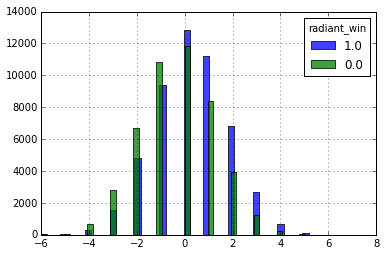

In [43]:
figsize = (25, 20)
hist_by_radiant_win(data, 'diff_boots_count')

In [43]:
remove = ['claymore_count',
         'chainmail_count', 
         'javelin_count', 
         'mithril_hammer_count', 
         'quarterstaff_count', 
         'gauntlets_count', 
         'robe_count', 
         'ogre_axe_count', 
         'blade_of_alacrity_count', 
         'staff_of_wizardry_count', 
         'gem_count', 
         'cloak_count', 
         'clarity_count', 
         #'ward_observer_count',    #!
         #'ward_sentry_count',       #!
         'courier_count',
         'travel_boots_count',
         'void_stone_count',
         'point_booster_count', 
         'vitality_booster_count', 
         'hand_of_midas_count', 
         'oblivion_staff_count', 
         'pers_count', 
         'mekansm_count', 
         'bracer_count', 
         'vladmir_count', 
         'buckler_count', 
         'urn_of_shadows_count', 
         'vanguard_count', 
         'blade_mail_count', 
         'armlet_count', 
         'sange_count', 
         'yasha_count', 
         'mask_of_madness_count', 
         'medallion_of_courage_count', 
         'ancient_janggo_count', 
         'shadow_amulet_count', 
         'ward_dispenser_count',
         'boots_of_elves_count', 
         'flask_count', 
         'dust_count'
          
         ]

In [44]:
f_ = [col_name[8:] for col_name in items_train.columns if col_name[:7]=='radiant']
f_  = [col_name for col_name in f_ if col_name not in outliers and col_name not in remove]
for f in f_:
    data['diff_{}'.format(f)] = data['radiant_{}'.format(f)] - data['dire_{}'.format(f)]
    data['diff_norm_{}'.format(f)] = (data['radiant_{}'.format(f)] - data['dire_{}'.format(f)]) / \
        sqrt(abs(data['radiant_{}'.format(f)]) + abs(data['dire_{}'.format(f)])).replace(0, 1)
    new_predictors.append('diff_norm_{}'.format(f))
    data.drop('radiant_{}'.format(f), axis=1, inplace=True)
    data.drop('dire_{}'.format(f), axis=1, inplace=True)

In [14]:
# The ratio of deaths to kills. Don't work.
data['r_deaths/kills'] = data[['r{}_deaths'.format(i) for i in range(1, 6)]].sum(
    axis=1) / data[['r{}_kills'.format(i) for i in range(1, 6)]].sum(axis=1).replace(0, 1)

data['d_deaths/kills'] = data[['d{}_deaths'.format(i) for i in range(1, 6)]].sum(
    axis=1) / data[['d{}_kills'.format(i) for i in range(1, 6)]].sum(axis=1).replace(0, 1)

for i in range(1, 6):
    data.drop('r{}_{}'.format(i, 'deaths'), inplace=True)
    data.drop('r{}_{}'.format(i, 'kills'), inplace=True)
    data.drop('d{}_{}'.format(i, 'deaths'), inplace=True)
    data.drop('d{}_{}'.format(i, 'kills'), inplace=True)

In [50]:
predictors = [col_name for col_name in data.columns if col_name != target and col_name not in remove]

In [51]:
predictors = [col_name for col_name in predictors if col_name[:4]!='dire' and col_name[:7]!='radiant']

In [56]:
n_samples =  data_train.shape[0]
data_train = data[:n_samples].copy()
data_test = data[n_samples:].copy()
data_test.drop(target, axis=1, inplace=True)

In [57]:
from sklearn.preprocessing import StandardScaler

norm = [col_name for col_name in data.columns
        if col_name not in new_predictors and
        col_name != target and
        col_name != 'first_blood_team' and col_name != 'first_blood_time' ]  

for col_name in norm:
    scaler = StandardScaler(with_mean = False)
    data_train[col_name] = scaler.fit_transform(data_train[col_name].astype(float))
    data_test[col_name] = scaler.transform(data_test[col_name].astype(float))

In [58]:
scaler = StandardScaler()
col_name  = 'first_blood_time'
data_train[col_name] = scaler.fit_transform(data_train[col_name].astype(float))
data_test[col_name] = scaler.transform(data_test[col_name].astype(float))

#scaler = StandardScaler()
#col_name = 'start_time'
#data_train[col_name] = scaler.fit_transform(data_train[col_name].astype(float))
#data_test[col_name] = scaler.transform(data_test[col_name].astype(float))

In [59]:
import os
os.environ['JOBLIB_TEMP_FOLDER'] = "/notebooks/tmp"

In [61]:
# Заменили выбросы у diff_branches_count, diff_enchanted_mango_count
param_test1 = {'C':[0.001, 0.01, 0.1, 10, 100]}

gsearch1 = GridSearchCV(estimator = LogisticRegression(C=1.0),
                                    param_grid = param_test1,
                                    scoring='log_loss',
                                    n_jobs=-1,
                                    cv=5,
                                    iid=False) 

gsearch1.fit(data_train[predictors], data_train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -0.58517, std: 0.01207, params: {'C': 0.001},
  mean: -0.58403, std: 0.01068, params: {'C': 0.01},
  mean: -0.58461, std: 0.01000, params: {'C': 0.1},
  mean: -0.58498, std: 0.00987, params: {'C': 10},
  mean: -0.58498, std: 0.00983, params: {'C': 100}],
 {'C': 0.01},
 -0.58402820851103199)

In [2]:
data_train = pd.read_csv('data_train.csv', index_col = 'match_id')
data_test = pd.read_csv('data_test.csv', index_col = 'match_id')
target  = 'radiant_win'
predictors = [col_name for col_name in data_test.columns]

In [64]:
logreg = LogisticRegression(C=0.01).fit(data_train[predictors], data_train[target])

In [65]:
y_pred = logreg.predict_proba(data_test[predictors])[:, 1]
y_pred = (y_pred - y_pred.min()) / (y_pred.max() - y_pred.min())

In [66]:
id_ = pd.DataFrame(data_test.index, columns = ['match_id'])
pred = pd.DataFrame(y_pred, columns = ['radiant_win'])
pred = pd.concat([id_, pred], axis = 1)
pred.to_csv('dota_pred.csv', index = False)

In [98]:
%%bash
git clone https://github.com/soboleva-daria/pyloggers.git
cd pyloggers/ && git pull

Already up-to-date.


Cloning into 'pyloggers'...


In [99]:
import sys
sys.path.insert(1,'pyloggers')
from telegram_logger import TelegramLogger
tl = TelegramLogger(name='dota', print_dual_logging=False)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.neighbors import KNeighborsClassifier

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_train[predictors],  data_train[target],
                                                    test_size=0.1, random_state=241)


LR_l2 = LogisticRegression(C=0.01).fit(X_train, y_train)
RF = RandomForestClassifier(n_estimators=500, min_samples_leaf=100).fit(X_train, y_train)
kNN =  KNeighborsClassifier(n_neighbors=99).fit(X_train, y_train)

y_pred_lr2 = LR_l2.predict_proba(X_test)[:, 1]
y_pred_rf = RF.predict_proba(X_test)[:, 1]
y_pred_kNN = kNN.predict_proba(X_test)[:, 1]
best_ans = [y_pred_lr2, y_pred_rf, y_pred_kNN]

In [117]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_train[predictors],  data_train[target],
                                                    test_size=0.1, random_state=241)


LR_l2 = LogisticRegression(C=0.01).fit(X_train, y_train)
LR_l1 = LogisticRegression(C=0.1, penalty='l1').fit(X_train, y_train)

y_pred_lr2 = LR_l2.predict_proba(X_test)[:, 1]
y_pred_lr1 = LR_l1.predict_proba(X_test)[:, 1]

best_ans = [y_pred_lr2, y_pred_lr1]

In [125]:
scores = {}
for w0 in linspace(0,1,30):
        w1 = 1 - w0
        if w1 >= 0 and w1 <=1:
            ans = best_ans[0] * w0 + best_ans[1]  * w1
            scores[w0, w1] = log_loss(y_test, ans)

In [106]:
# Сonvex combinations don't work :(
scores = {}
for w0 in linspace(0,1,30):
    for w1 in linspace(0,1,30):
        w2 = 1 - w0 - w1
        if w2 >= 0 and w2 <=1:
            ans = exp(log(best_ans[0] + 1) * w0 + log(best_ans[1] + 1) * w1 + log(best_ans[2] + 1) * w2) -1
            scores[w0, w1] = log_loss(y_test, ans)

In [54]:
# Attempts to average ans
LR_l2 =  LogisticRegression(C=0.01).fit(data_train[predictors], data_train[target])
RF = RandomForestClassifier().fit(data_train[predictors], data_train[target])
y_pred_lr2 = LR_l2.predict_proba(data_test[predictors])[:, 1]
y_pred_rf = RF.predict_proba(data_test[predictors])[:, 1]
scores = []


kf = KFold(data_train.shape[0], 5)
for i, j in kf:
    data_train_ = data_train.iloc[i1]
    data_test_ = data_train.iloc[j1]
    
    LR_l2 =  LogisticRegression(C=0.01).fit(data_train_[predictors], data_train_[target])
    RF = RandomForestClassifier().fit(data_train_[predictors], data_train_[target])
    kNN = KNeighborsClassifier().fit(data_train_[predictors], data_train_[target])
    
    y_pred_lr2 = LR_l2.predict_proba(data_test_[predictors])[:, 1]
    y_pred_rf = RF.predict_proba(data_test_[predictors])[:, 1]
    y_pred_kNN = kNN.predict_proba(data_test_[predictors])[:, 1]
    
    scores.append(log_loss(data_test_[target], (y_pred_lr2 + y_pred_rf + y_pred_kNN) / 3))
    
print(np.mean(scores))

0.602044432458


In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.neighbors import KNeighborsClassifier

LR_l2 = LogisticRegression(C=0.01).fit(data_train[predictors], data_train[target])
y_pred_lr2 = LR_l2.predict_proba(data_test[predictors])[:, 1]

RF = RandomForestClassifier().fit(data_train[predictors], data_train[target])
y_pred_rf = RF.predict_proba(data_test[predictors])[:, 1]

kNN = KNeighborsClassifier().fit(data_train[predictors], data_train[target])
y_pred_kNN = kNN.predict_proba(data_test[predictors])[:, 1]

ans = {'LR_lr2':y_pred_lr2, 'RF':y_pred_rf, 'kNN': y_pred_kNN }
pd.DataFrame(ans).corr()

,LR_lr2,RF,kNN
LR_lr2,1.000000,0.741334,0.579214
RF,0.741334,1.000000,0.492912
kNN,0.579214,0.492912,1.000000
